# Handling the data
The data needs to be seperated on data which model will be run on and some unnecessary atributes like name, club, nationality. There is also need of creating class of each player to make it classiffication problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_validate 
from sklearn.preprocessing import Normalizer, StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from imblearn.metrics import geometric_mean_score
import re

In [2]:
pd.set_option("display.max_columns", None, "display.max_rows", 20)

In [3]:
df = pd.read_csv('data.csv', sep=',', header=0, index_col=0)
df = df.drop(['Photo', 'Club Logo', 'Flag'], axis=1)
df_ID = df[['ID', 'Name', 'Nationality', 'Club']]
df = df.drop(['ID', 'Name', 'Nationality', 'Club'], axis=1)
df_money = df[['Value', 'Wage', 'Release Clause']]
df = df.drop(['Value', 'Wage', 'Release Clause'], axis=1)
df_misc = df[['Special', 'Preferred Foot', 'Work Rate', 'Real Face', 'Body Type', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until']]
df = df.drop(['Special', 'Preferred Foot', 'Work Rate', 'Real Face', 'Body Type', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until'], axis=1)
print(df.columns)

Index(['Age', 'Overall', 'Potential', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Position', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW',
       'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
       'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')


In [4]:
df_GK = df[df['Position']=='GK'].drop(['LS', 'ST', 'RS', 'LW','LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'], axis=1)
df_GK = df_GK.drop('Position', axis=1)
df_GK = df_GK.dropna(axis='rows')
df_X = df.drop(index=df_GK.index)
df_X = df_X.drop(['Position', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'], axis=1)
df_X = df_X.dropna(axis='rows')

In [5]:
def extract_skill(x):
    return int(re.findall('\d+', x)[0])

def extract_weight(x):
    weight = float(re.findall('\d+', x)[0])
    weight = weight * 0.45359
    return weight

def extract_height(x):
    foot, inches = np.array(re.findall('\d+', x)).astype(np.float)
    height = (foot * 0.3048 + inches * 0.0254) * 100
    return height

df_X['Height'] = df_X['Height'].apply(extract_height)
df_X['Weight'] = df_X['Weight'].apply(extract_weight)
skill_rows_normal = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']
df_X[skill_rows_normal] = df_X[skill_rows_normal].apply(lambda row: [extract_skill(item) for item in row])

df_GK['Height'] = df_GK['Height'].apply(extract_height)
df_GK['Weight'] = df_GK['Weight'].apply(extract_weight)

In [6]:
df_y_overall = df_X['Overall']
df_y_potential = df_X['Potential']
df_X = df_X.drop(['Overall', 'Potential'], axis=1)

df_y_overall_GK = df_GK['Overall']
df_y_potential_GK = df_GK['Potential']
df_GK = df_GK.drop(['Overall', 'Potential'], axis=1)

In [7]:
df_X.describe()

Age  International Reputation     Weak Foot   Skill Moves  \
count  16122.000000              16122.000000  16122.000000  16122.000000   
mean      25.005272                  1.115494      3.004590      2.532502   
std        4.547106                  0.396542      0.636915      0.617823   
min       16.000000                  1.000000      1.000000      2.000000   
25%       21.000000                  1.000000      3.000000      2.000000   
50%       25.000000                  1.000000      3.000000      2.000000   
75%       28.000000                  1.000000      3.000000      3.000000   
max       41.000000                  5.000000      5.000000      5.000000   

             Height        Weight            LS            ST            RS  \
count  16122.000000  16122.000000  16122.000000  16122.000000  16122.000000   
mean     180.388683     74.449475     57.815470     57.815470     57.815470   
std        6.430065      6.716495      9.108442      9.108442      9.108442   
min      154.940000     49.894900     31.000000     31.000000     31.000000   
25%      175.260000     69.852860     52.000000     52.000000     52.000000   
50%      180.340000     73.935170     58.000000     58.000000     58.000000   
75%      185.420000     78.924660     64.000000     64.000000     64.000000   
max      203.200000    110.222370     91.000000     91.000000     91.000000   

                 LW            LF            CF            RF            RW  \
count  16122.000000  16122.000000  16122.000000  16122.000000  16122.000000   
mean      59.037650     58.719390     58.719390     58.719390     59.037650   
std        9.859751      9.820012      9.820012      9.820012      9.859751   
min       25.000000     27.000000     27.000000     27.000000     25.000000   
25%       53.000000     53.000000     53.000000     53.000000     53.000000   
50%       60.000000     60.000000     60.000000     60.000000     60.000000   
75%       66.000000     66.000000     66.000000     66.000000     66.000000   
max       92.000000     93.000000     93.000000     93.000000     92.000000   

                LAM           CAM           RAM            LM           LCM  \
count  16122.000000  16122.000000  16122.000000  16122.000000  16122.000000   
mean      58.983129     58.983129     58.983129     59.734710     58.220878   
std        9.748896      9.748896      9.748896      9.231659      8.780694   
min       27.000000     27.000000     27.000000     27.000000     30.000000   
25%       53.000000     53.000000     53.000000     54.000000     52.000000   
50%       60.000000     60.000000     60.000000     61.000000     59.000000   
75%       66.000000     66.000000     66.000000     66.000000     64.000000   
max       93.000000     93.000000     93.000000     91.000000     88.000000   

                 CM           RCM            RM           LWB           LDM  \
count  16122.000000  16122.000000  16122.000000  16122.000000  16122.000000   
mean      58.220878     58.220878     59.734710     57.513274     56.825146   
std        8.780694      8.780694      9.231659      8.956115     10.068077   
min       30.000000     30.000000     27.000000     30.000000     28.000000   
25%       52.000000     52.000000     54.000000     51.000000     49.000000   
50%       59.000000     59.000000     61.000000     58.000000     58.000000   
75%       64.000000     64.000000     66.000000     64.000000     64.000000   
max       88.000000     88.000000     91.000000     85.000000     87.000000   

                CDM           RDM           RWB            LB           LCB  \
count  16122.000000  16122.000000  16122.000000  16122.000000  16122.000000   
mean      56.825146     56.825146     57.513274     56.806786     55.614626   
std       10.068077     10.068077      8.956115      9.516241     11.702658   
min       28.000000     28.000000     30.000000     29.000000     25.000000   
25%       49.000000     49.000000     51.000000     50.000000     46.000000   


In [8]:
df_GK.describe()

Age  International Reputation    Weak Foot  Skill Moves  \
count  2025.000000               2025.000000  2025.000000       2025.0   
mean     26.043457                  1.095802     2.489877          1.0   
std       5.465042                  0.374202     0.666847          0.0   
min      16.000000                  1.000000     1.000000          1.0   
25%      22.000000                  1.000000     2.000000          1.0   
50%      25.000000                  1.000000     3.000000          1.0   
75%      30.000000                  1.000000     3.000000          1.0   
max      45.000000                  5.000000     5.000000          1.0   

            Height       Weight     Crossing    Finishing  HeadingAccuracy  \
count  2025.000000  2025.000000  2025.000000  2025.000000      2025.000000   
mean    188.192049    81.965841    14.257284    12.016296        14.368889   
std       4.761320     6.244363     3.977764     3.992734         3.933956   
min     172.720000    59.873880     5.000000     2.000000         4.000000   
25%     185.420000    78.017480    12.000000     9.000000        12.000000   
50%     187.960000    82.099790    13.000000    12.000000        14.000000   
75%     190.500000    86.182100    16.000000    15.000000        16.000000   
max     205.740000   107.047240    45.000000    27.000000        47.000000   

       ShortPassing      Volleys    Dribbling        Curve   FKAccuracy  \
count   2025.000000  2025.000000  2025.000000  2025.000000  2025.000000   
mean      27.269136    12.397037    13.856296    14.707654    14.464198   
std        7.840124     4.293505     4.300082     4.454254     4.682807   
min        7.000000     4.000000     4.000000     6.000000     3.000000   
25%       22.000000     9.000000    11.000000    12.000000    12.000000   
50%       27.000000    12.000000    13.000000    14.000000    13.000000   
75%       31.000000    15.000000    16.000000    17.000000    16.000000   
max       66.000000    31.000000    32.000000    55.000000    72.000000   

       LongPassing  BallControl  Acceleration  SprintSpeed      Agility  \
count  2025.000000  2025.000000   2025.000000  2025.000000  2025.000000   
mean     25.808395    19.949630     38.320000    38.712099    40.201481   
std       8.219015     5.888912     11.016396    10.757963    11.428152   
min       9.000000     5.000000     12.000000    12.000000    14.000000   
25%      20.000000    16.000000     30.000000    31.000000    32.000000   
50%      24.000000    20.000000     39.000000    40.000000    38.000000   
75%      31.000000    23.000000     46.000000    46.000000    48.000000   
max      66.000000    48.000000     67.000000    65.000000    78.000000   

         Reactions      Balance    ShotPower      Jumping      Stamina  \
count  2025.000000  2025.000000  2025.000000  2025.000000  2025.000000   
mean     58.926420    43.098272    22.533333    57.698272    30.461728   
std      10.302635    11.037831     6.934690    11.498553     7.817688   
min      30.000000    16.000000     2.000000    15.000000    12.000000   
25%      52.000000    35.000000    19.000000    52.000000    24.000000   
50%      60.000000    43.000000    22.000000    59.000000    30.000000   
75%      67.000000    51.000000    24.000000    66.000000    36.000000   
max      90.000000    77.000000    70.000000    85.000000    62.000000   

          Strength    LongShots   Aggression  Interceptions  Positioning  \
count  2025.000000  2025.000000  2025.000000    2025.000000  2025.000000   
mean     60.602963    12.653333    26.371852      17.052346    11.258765   
std      11.113295     4.336548     7.835103       5.999854     4.181552   
min      17.000000     3.000000    11.000000       3.000000     2.000000   
25%      54.000000     9.000000    20.000000      12.000000     8.000000   
50%      62.000000    13.000000    25.000000      17.000000    11.000000   
75%      68.000000    16.000000    32.000000      22.000000    14.000000   
max      85.000000

Now we display distribution of overall score to gain some intuition about this feature. We see that it is similar to normal distribution.

Text(0.5, 1.0, 'Overall score distribution')

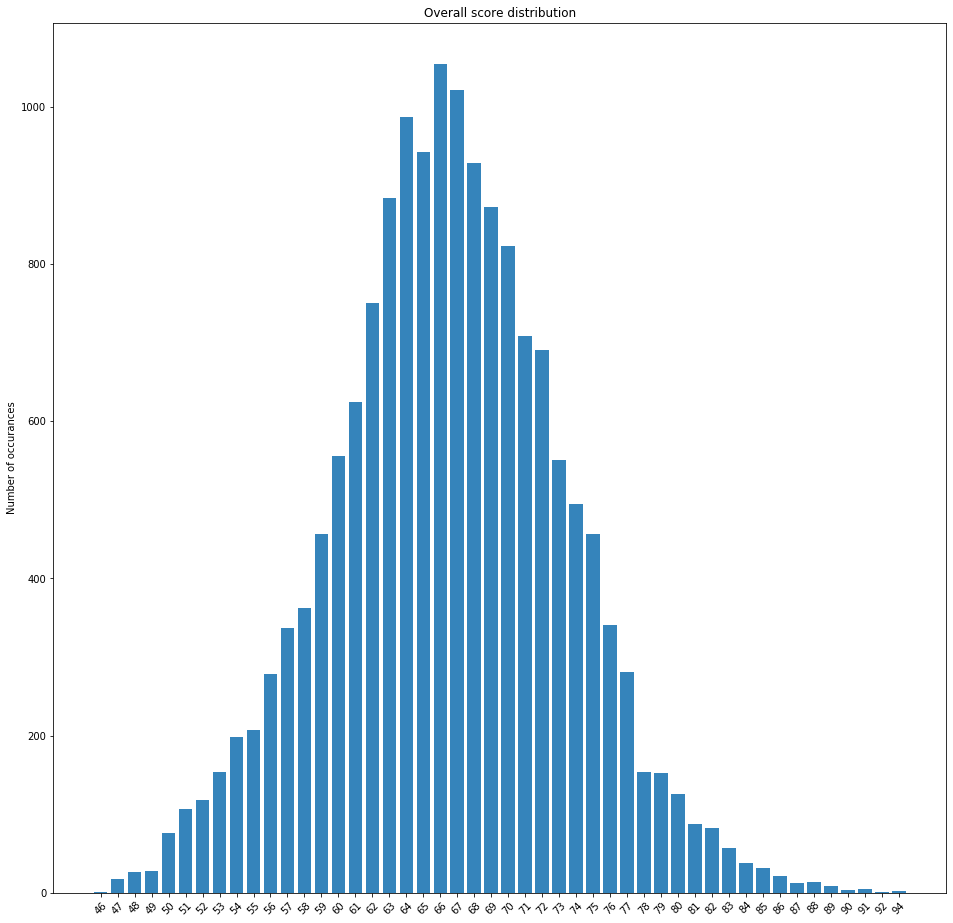

In [9]:
t = df_y_overall.values
unique, counts = np.unique(t, return_counts=True)
y_pos = range(len(unique))
plt.figure(figsize=(16,16))
plt.bar(y_pos, counts, align='center', alpha=0.9)
plt.xticks(y_pos, unique, rotation=45)
plt.ylabel('Number of occurances')
plt.title('Overall score distribution')
# bincount = np.bincount(t)
# print(unique)

In [7]:
X = df_X.values
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
y = df_y_overall.values
y_discrete = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='kmeans').fit_transform(y.reshape(-1, 1))[:,0].astype(np.int)

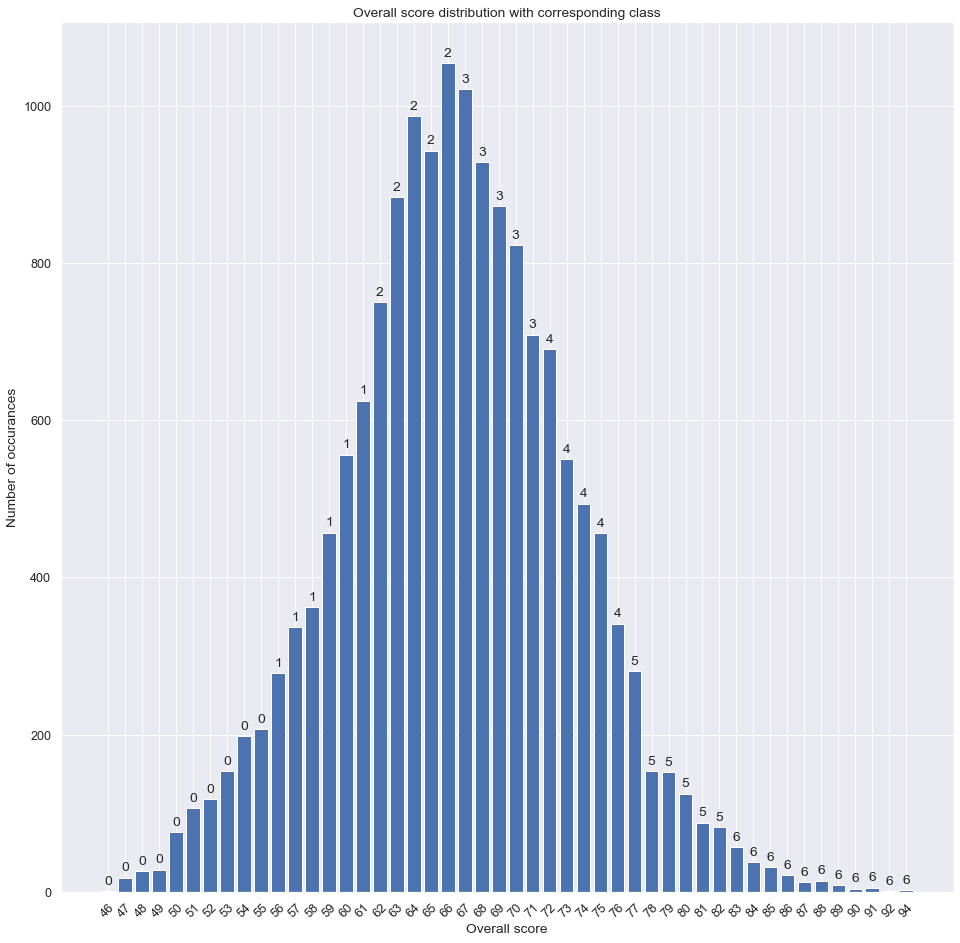

In [76]:
unique, counts = np.unique(y.astype(np.int), return_counts=True)
labels = [int(y_discrete[np.where(y.astype(np.int) == item)[0][0]]) for item in unique]


y_pos = range(len(unique))
fig, ax1 = plt.subplots(figsize=(16,16))
ax1.bar(y_pos, counts, align='center')
# ax1.title(column)
plt.sca(ax1)
plt.xticks(y_pos, unique, rotation=45)
plt.xlabel('Overall score')
plt.ylabel('Number of occurances')
plt.title('Overall score distribution with corresponding class')
rects = ax1.patches
# height = np.max(np.array([item.get_height() for item in rects]))

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
plt.savefig('score.eps', format='eps')

We use k-means strategy for discretization as it is best compared to other methods (uniform and quantile) for labeling. We want to ensure that every class is representative (there is problem with class 6 as there are very few players which have score above 85) and to be wide enough (contain many overall scores). Uniform strategy makes distribution of classes too centrilized with class 0 and 6 being too small, while quantile strategy makes middle classes contain too little scores (f.e. number of players with averege score of 67 is greater than number of players with score above 85)

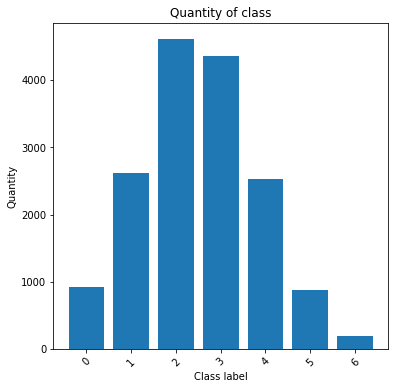

In [11]:
unique_y, counts_y = np.unique(y_discrete, return_counts=True)
y_pos = range(len(unique_y))
plt.figure(figsize=(6,6))
plt.bar(y_pos, counts_y, align='center')
plt.xticks(y_pos, unique_y, rotation=45)
plt.xlabel('Class label')
plt.ylabel('Quantity')
plt.title('Quantity of class')
plt.savefig('class_balance.eps', format='eps')

We show correlation matrix to see if there are possible irrelevant features

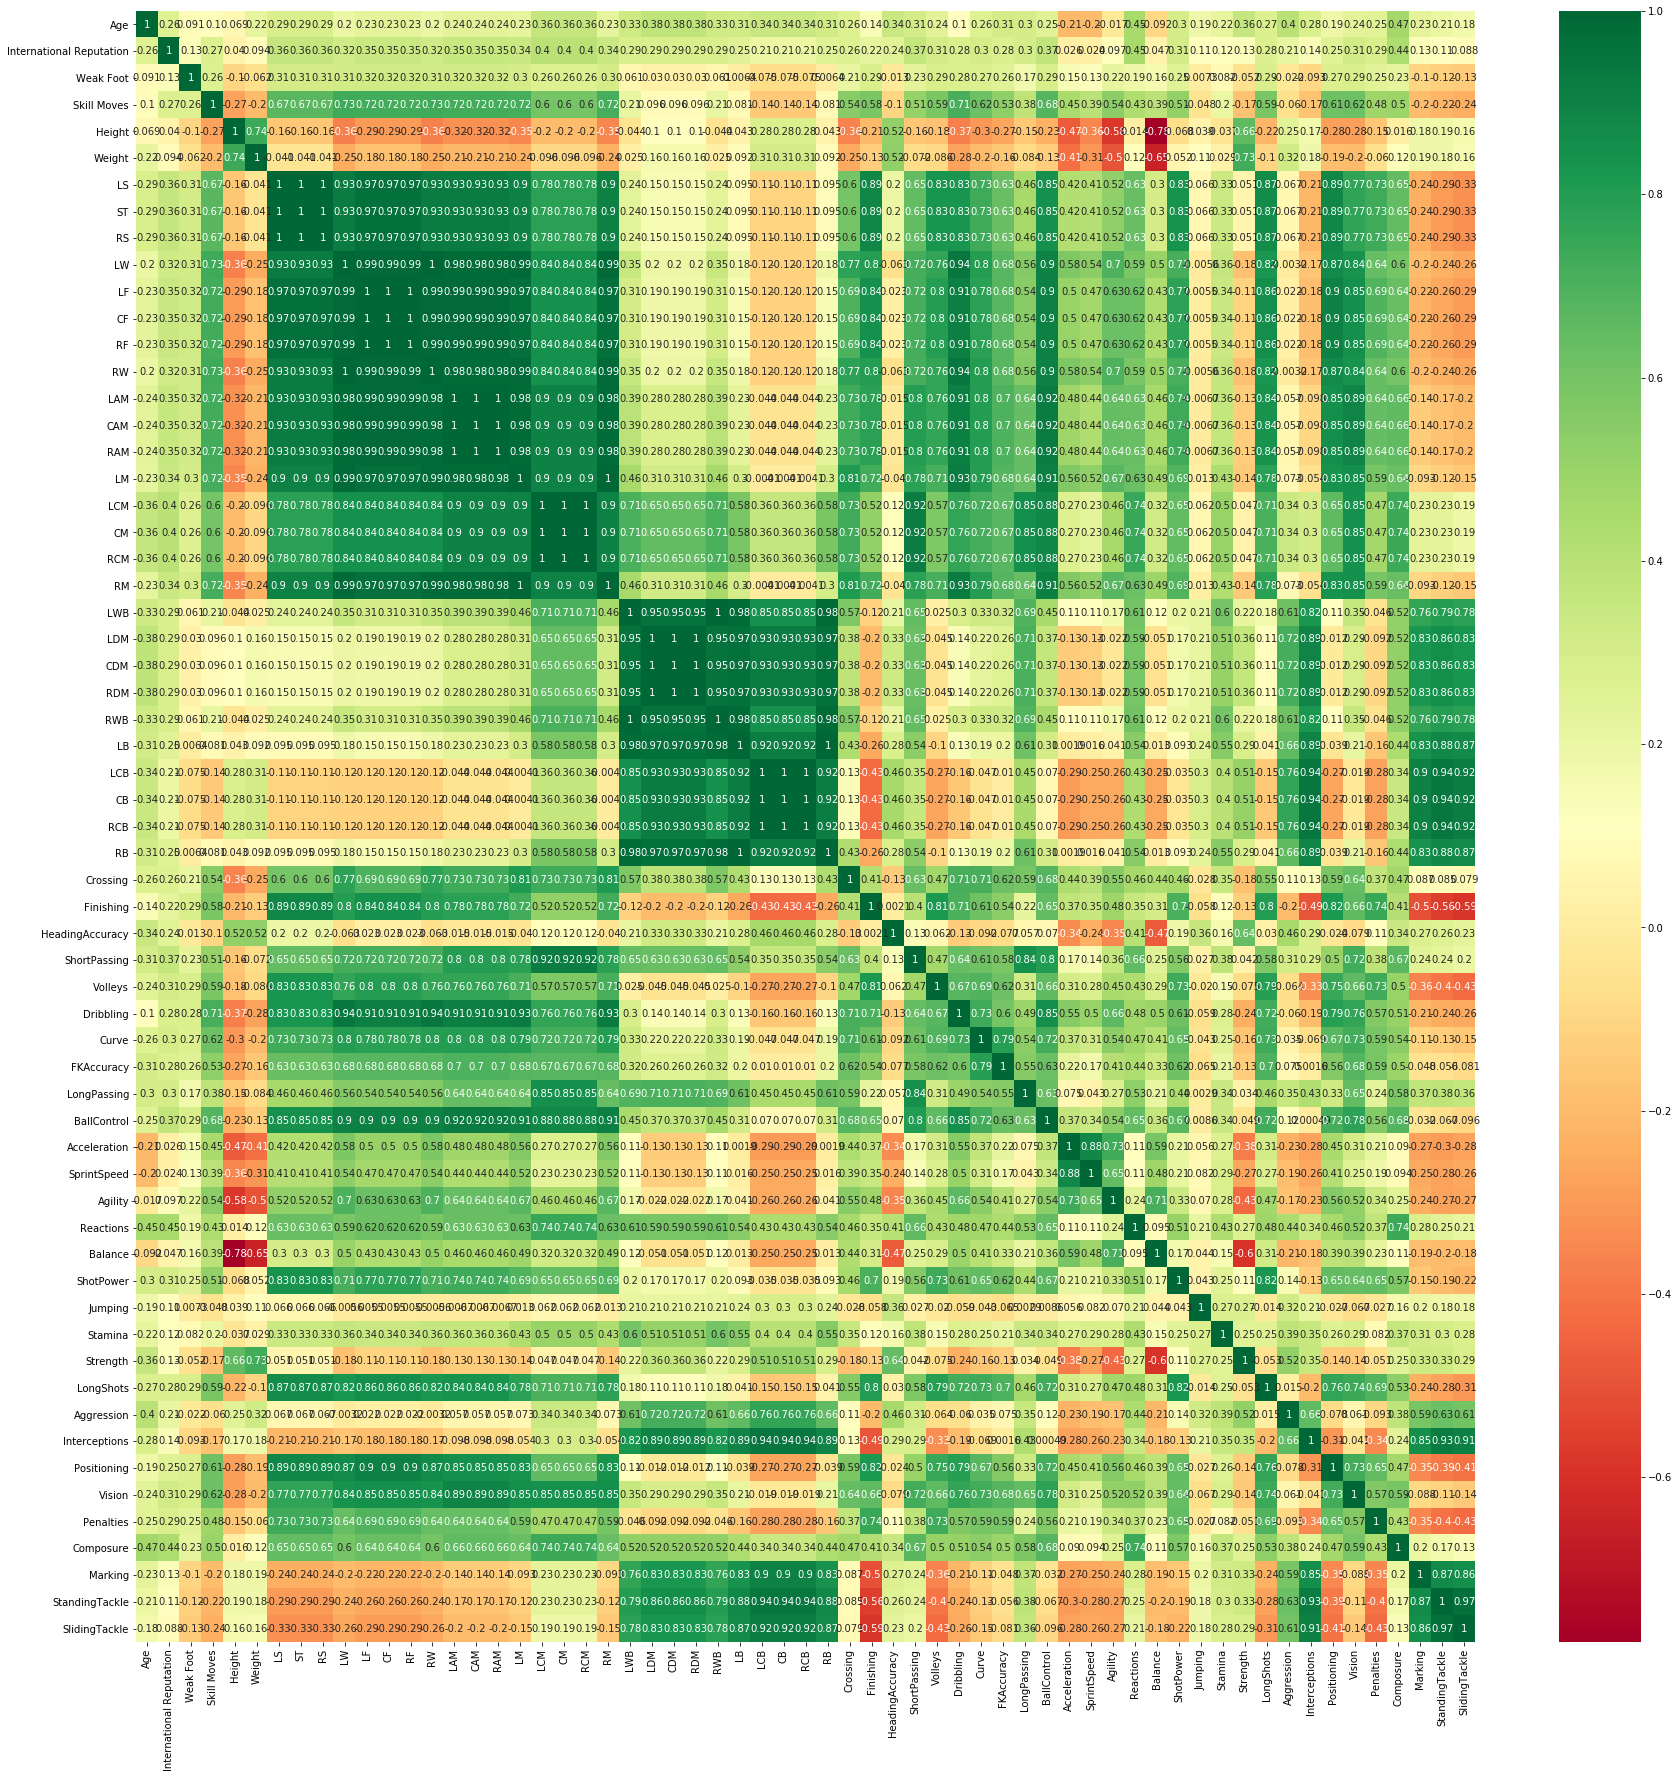

In [20]:
plt.figure(figsize=(30,30))
g=sns.heatmap(df_X.corr(),annot=True,cmap="RdYlGn")
plt.savefig('corr.eps', format='eps')

In [21]:
corr = df_X.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if np.abs(corr.iloc[i,j]) >= 0.95:
            if columns[j]:
                columns[j] = False
selected_columns = df_X.columns[columns]
df_X_corr = df_X[selected_columns]
X_corr = df_X_corr.values

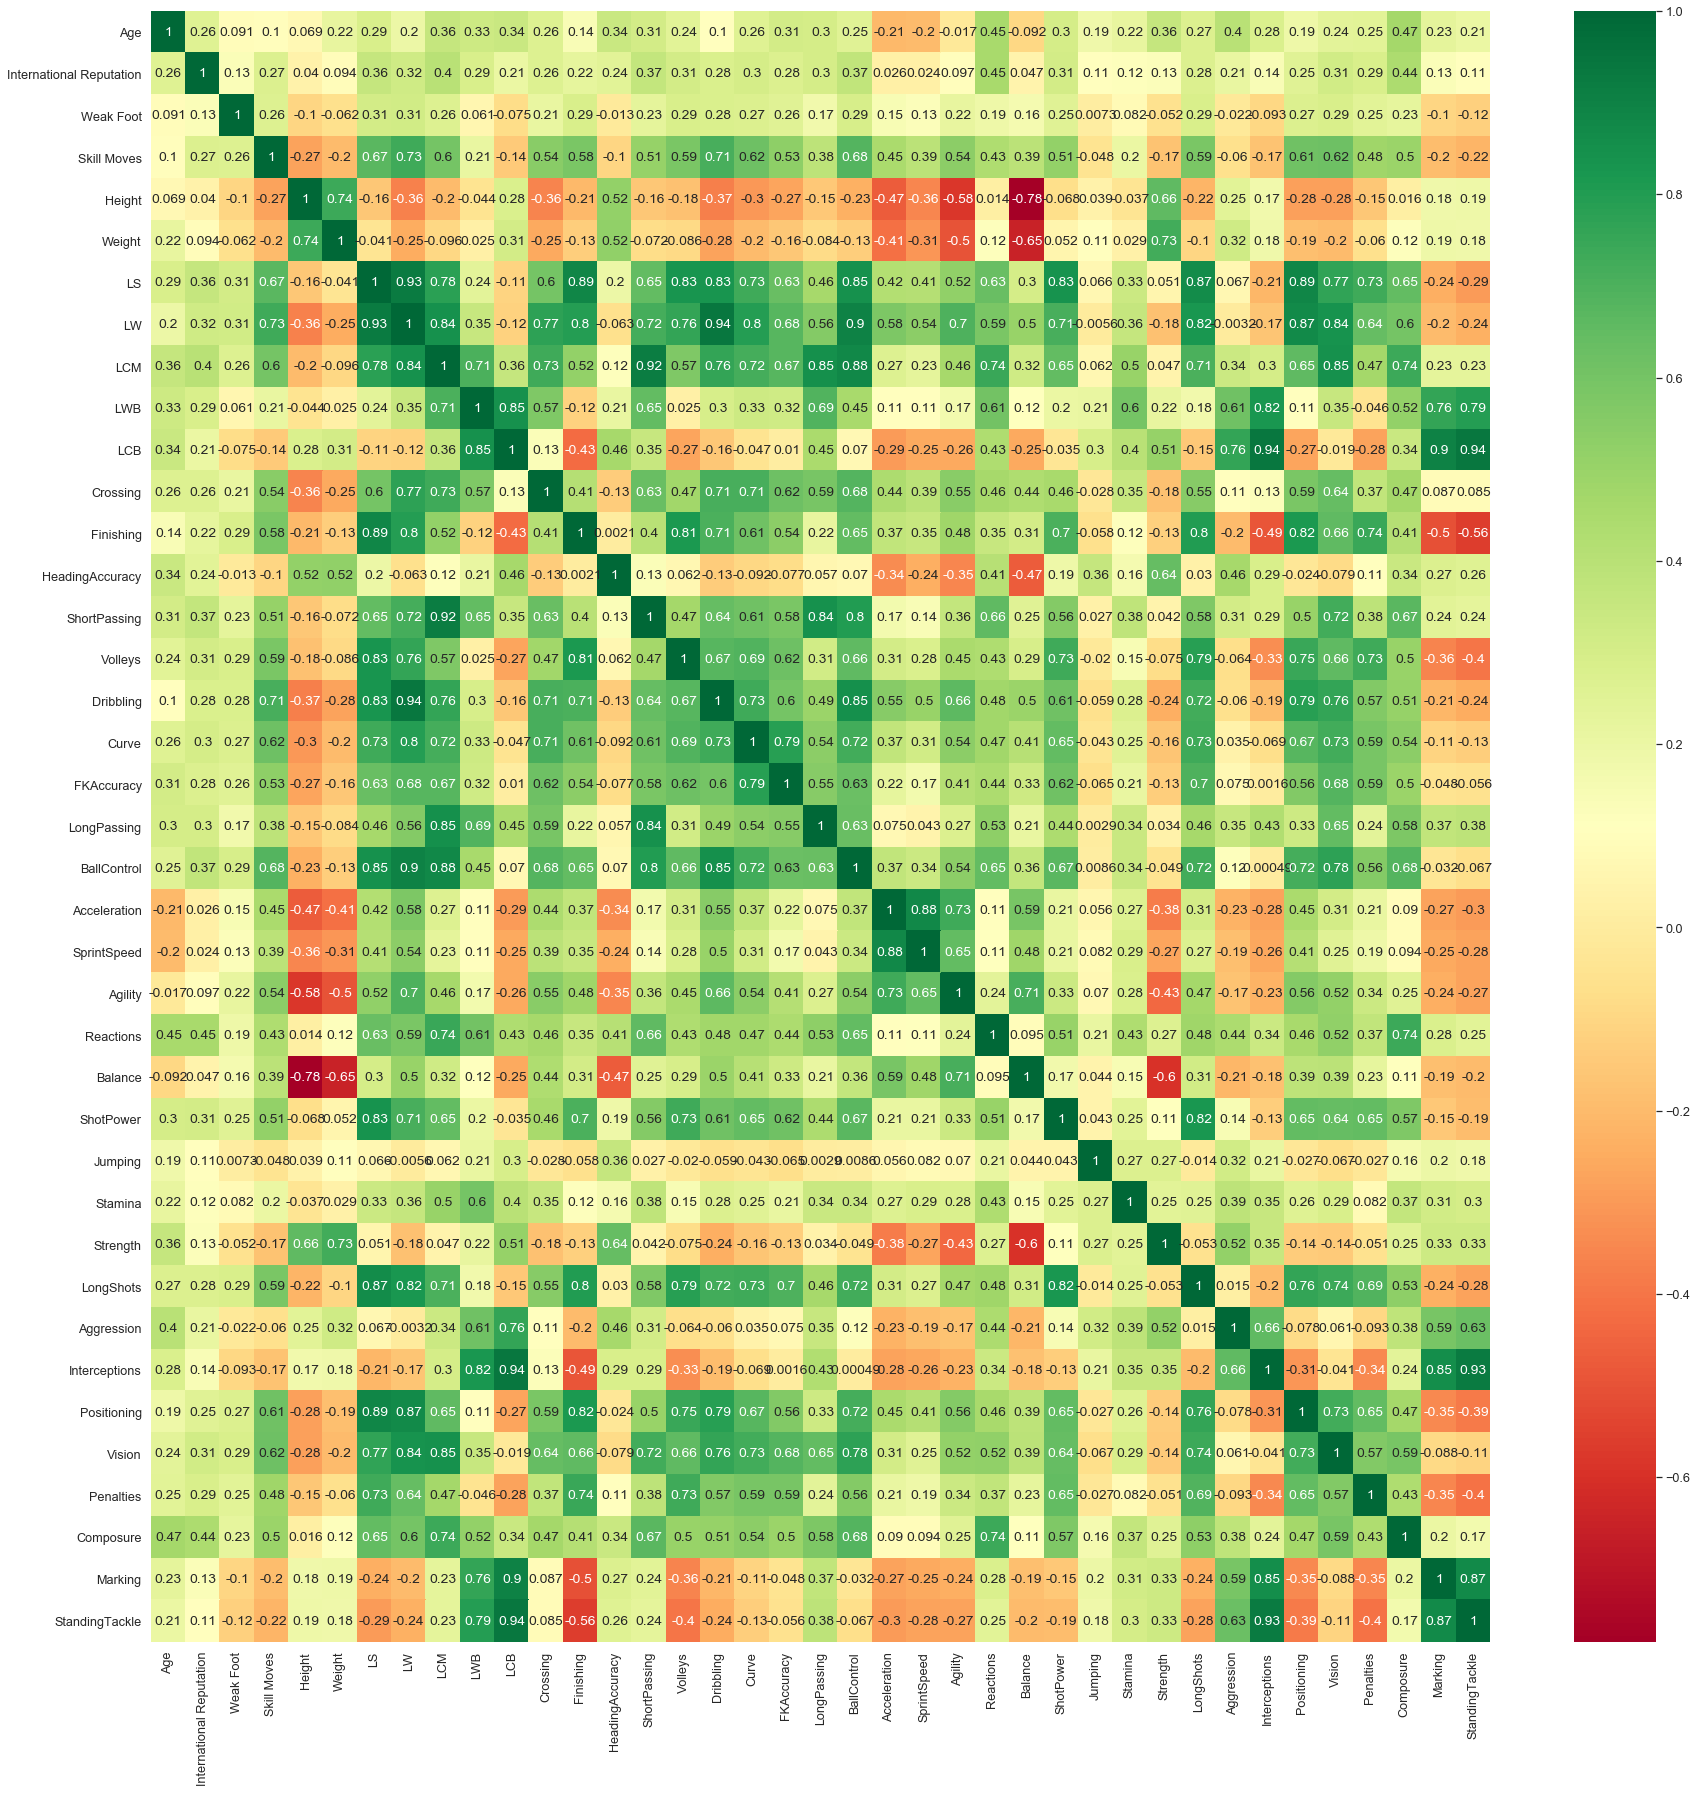

In [59]:
plt.figure(figsize=(30,30))
sns.set(font_scale=1.15)
sns.heatmap(df_X_corr.corr(), annot=True, cmap="RdYlGn")
plt.savefig('corr2.eps', format='eps')

We show distribution of each feature to see if there are some weird stuff going on.

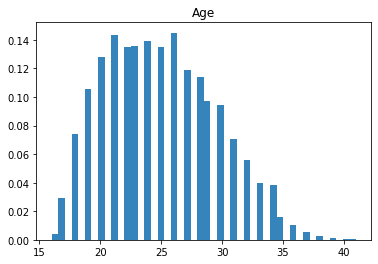

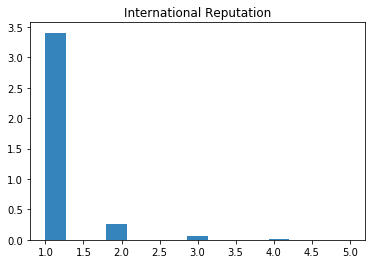

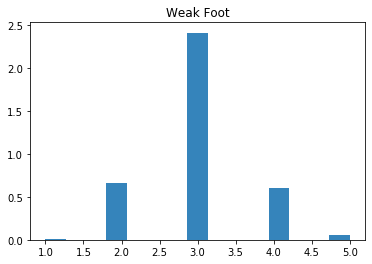

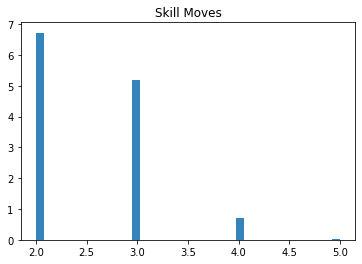

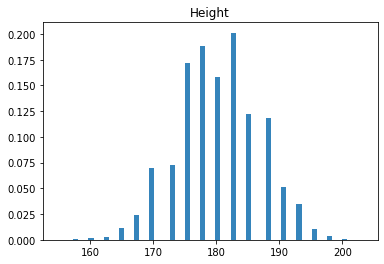

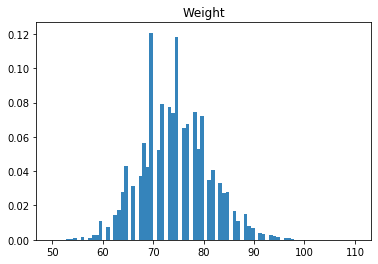

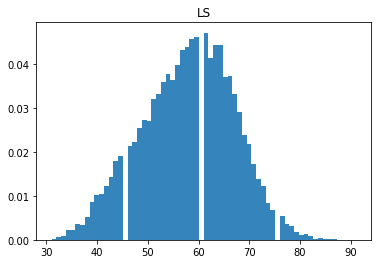

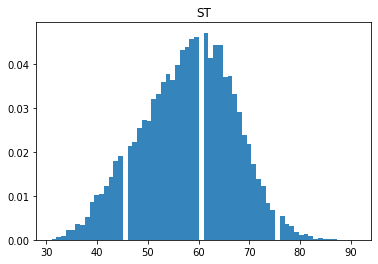

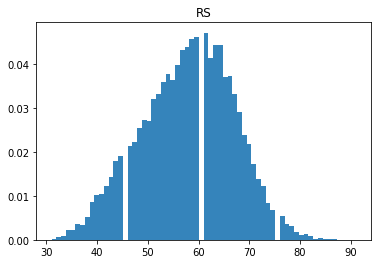

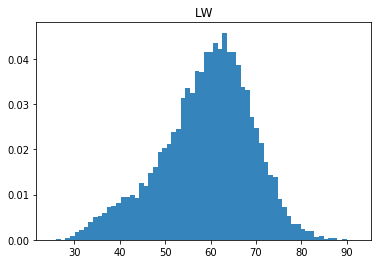

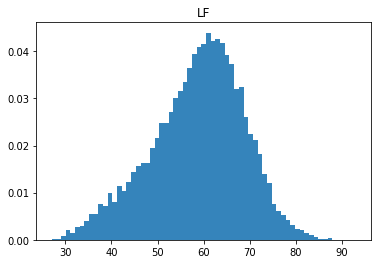

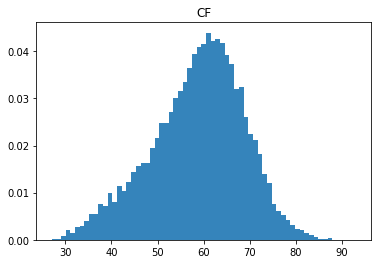

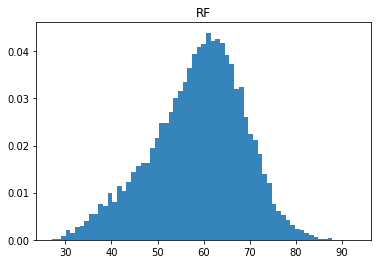

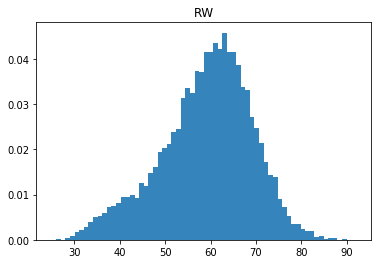

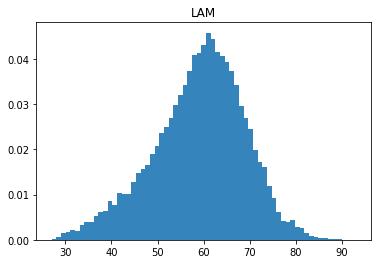

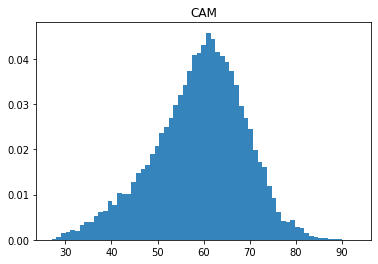

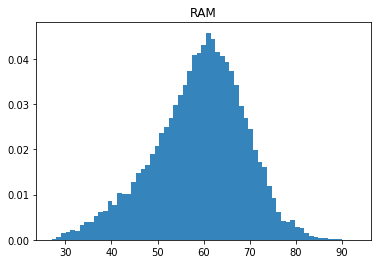

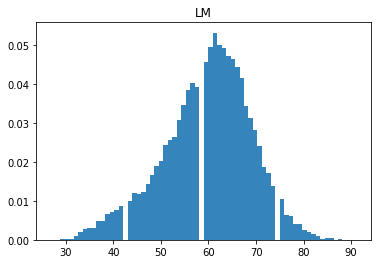

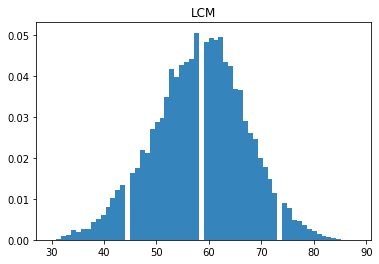

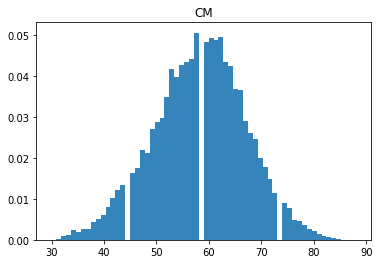

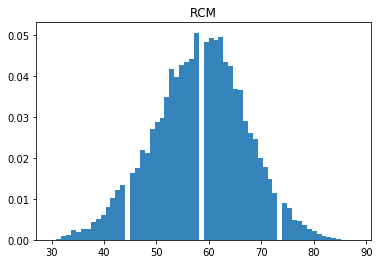

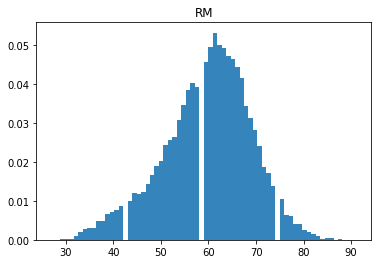

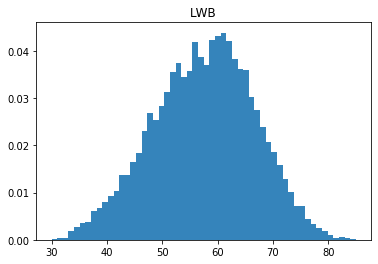

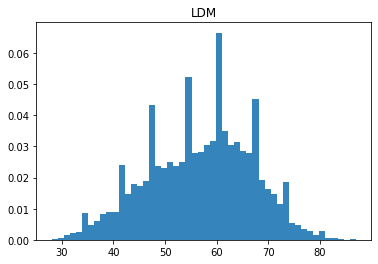

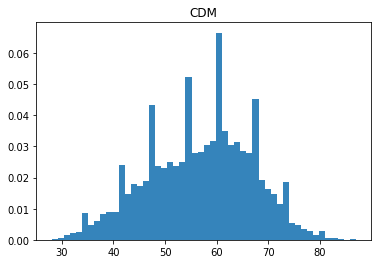

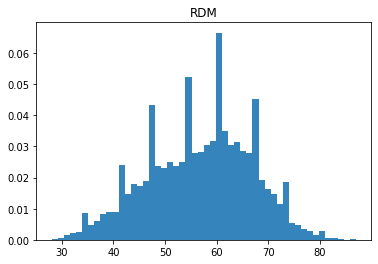

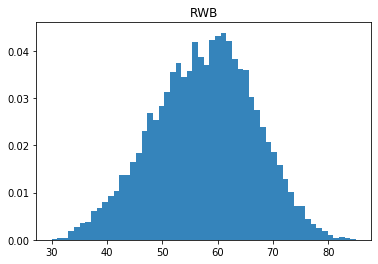

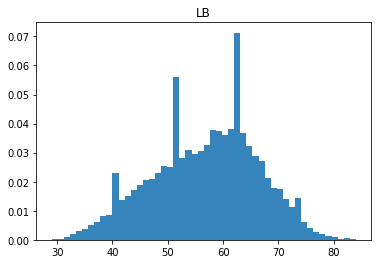

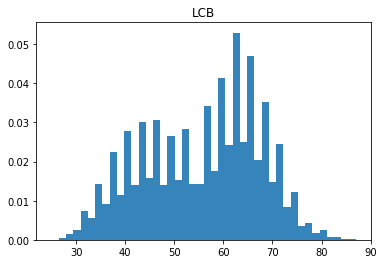

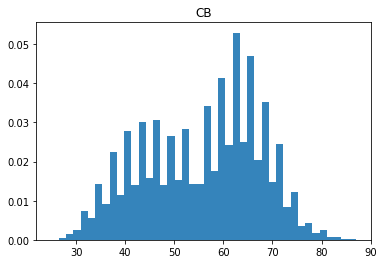

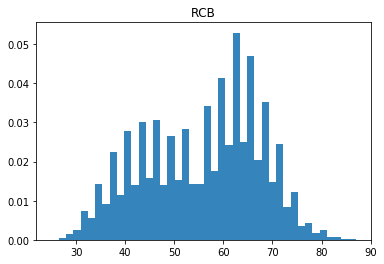

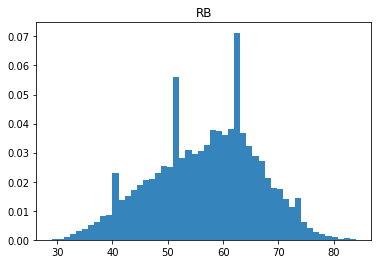

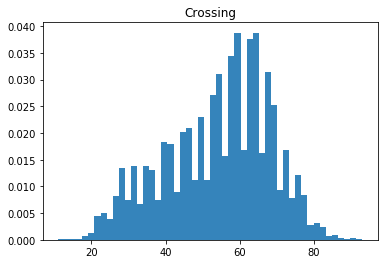

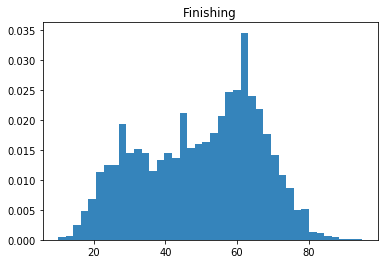

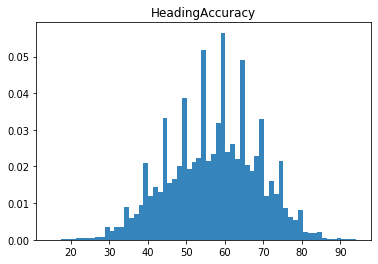

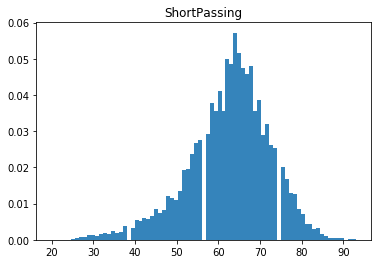

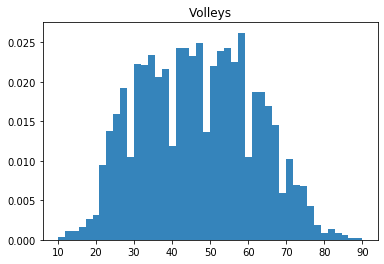

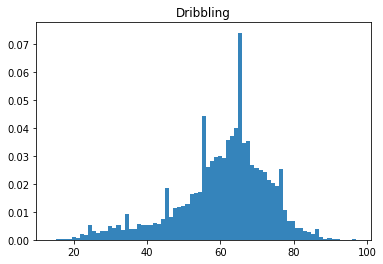

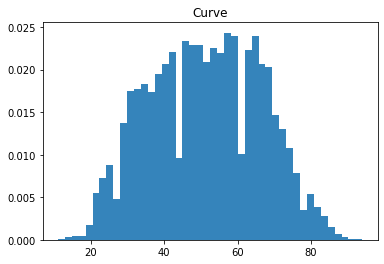

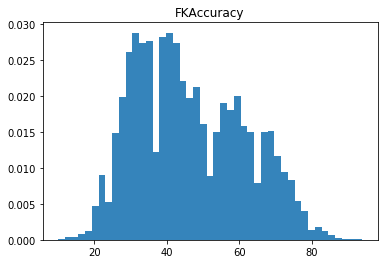

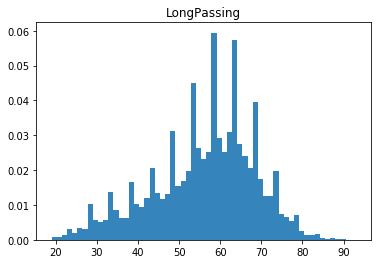

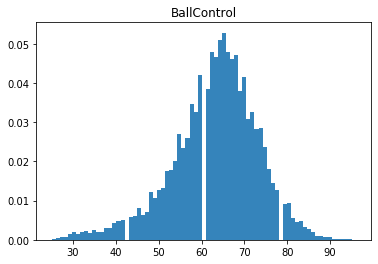

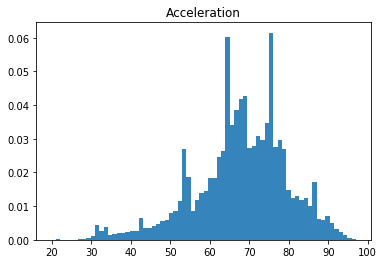

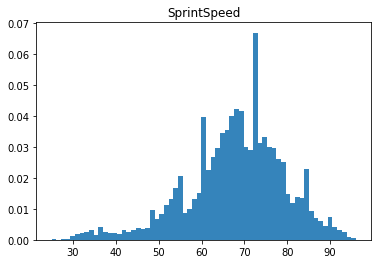

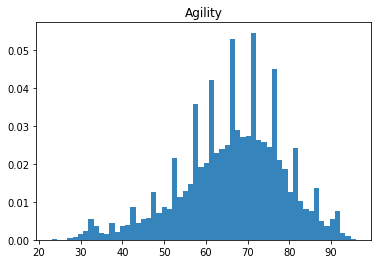

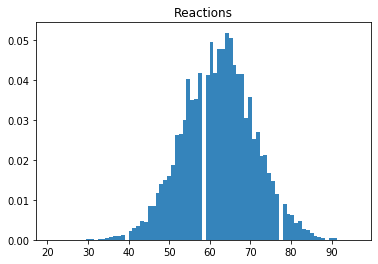

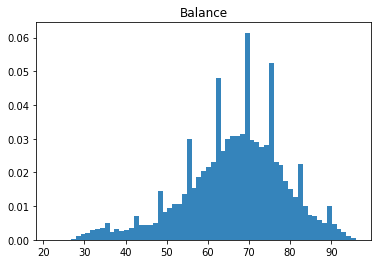

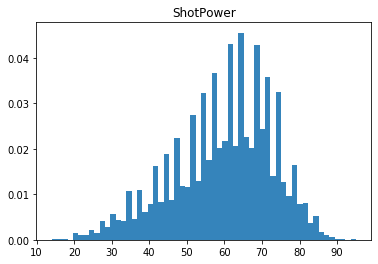

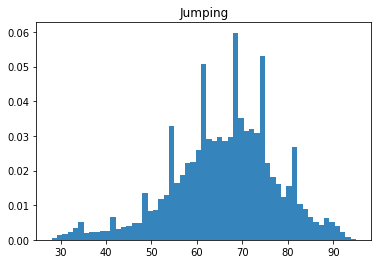

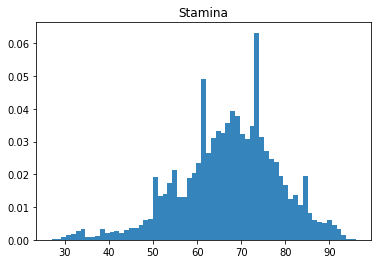

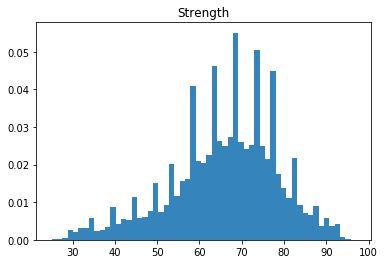

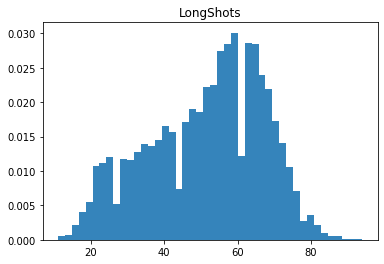

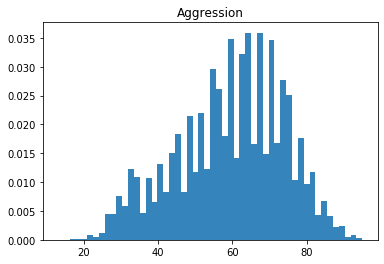

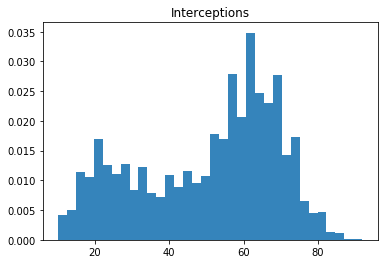

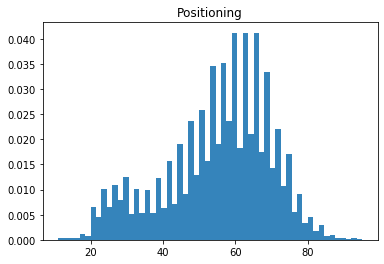

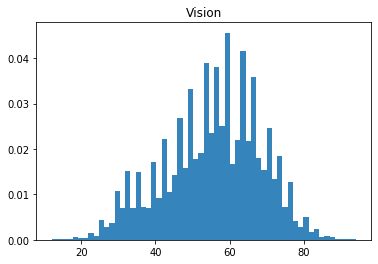

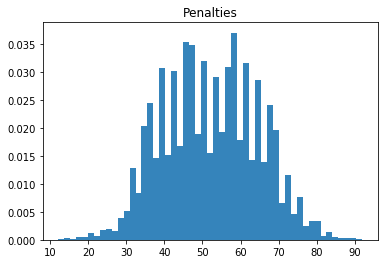

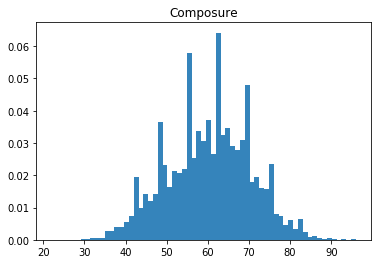

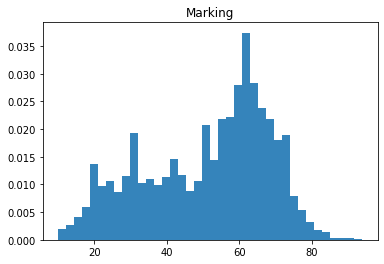

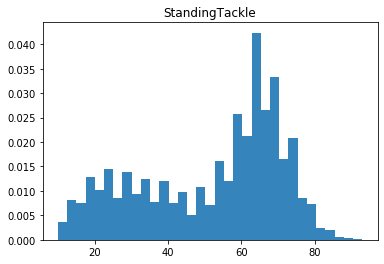

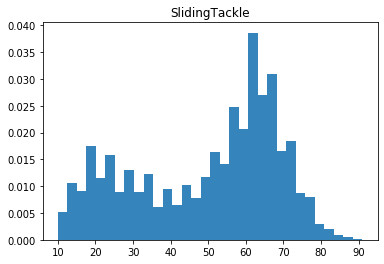

In [168]:
columns = df_X.columns
for column in columns:
    plt.figure()
    plt.hist(df_X[column], bins='auto', alpha=0.9, density=True)
    plt.title(column)
    plt.show()

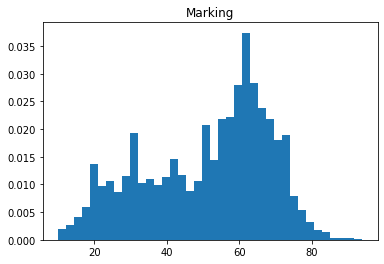

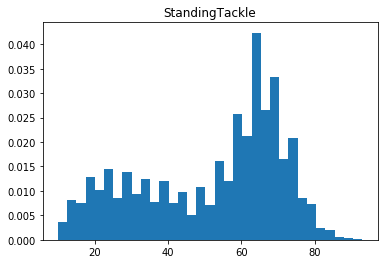

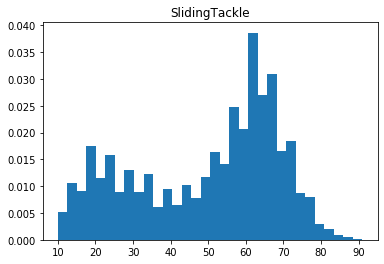

In [54]:
columns2file = ['Marking', 'StandingTackle', 'SlidingTackle']
for column in columns2file:
    plt.figure()
    plt.hist(df_X[column], bins='auto', density=True)
    plt.title(column)
    filename = column + '.eps'
    plt.savefig(filename, format='eps')

We use different feature selection algorithms and compare their outcomes to see which feature are unnecessary

In [72]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

feature_name = list(df_X.columns)
# no of maximum features we need to select
num_feats=30

# def cor_selector(X, y, num_feats):
#     cor_list = []
#     feature_names = X.columns.tolist()
#     # calculate the correlation with y for each feature
#     for i in feature_names:
#         cor = np.corrcoef(X[i], y)[0, 1]
#         cor_list.append(cor)
#     # replace NaN with 0
#     cor_list = [0 if np.isnan(i) else i for i in cor_list]
#     # feature name
#     print(np.abs(cor_list)[55])
#     print(np.argsort(np.abs(cor_list))[-num_feats:])
#     cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
#     # feature selection? 0 for not select, 1 for select
#     cor_support = [True if i in cor_feature else False for i in feature_names]
#     return cor_support, cor_feature

# cor_support, cor_feature = cor_selector(df_X, y_discrete, num_feats)
# print(cor_feature)

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y_discrete)
chi_support = chi_selector.get_support()
chi_feature = df_X.loc[:,chi_support].columns.tolist()
print(chi_feature)

estimator_svc = SVC(kernel='linear')
rfe_selector = RFE(estimator=estimator_svc, n_features_to_select=num_feats, step=5, verbose=0)
rfe_selector.fit(X_norm, y_discrete)
rfe_support = rfe_selector.get_support()
rfe_feature = df_X.loc[:,rfe_support].columns.tolist()
print(rfe_feature)

embeded_lr_selector = SelectFromModel(LogisticRegression(max_iter=1000, solver='saga'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y_discrete)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = df_X.loc[:,embeded_lr_support].columns.tolist()
print(embeded_lr_feature)

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y_discrete)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = df_X.loc[:,embeded_rf_support].columns.tolist()
print(embeded_rf_feature)

pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(30)



['Age', 'International Reputation', 'Skill Moves', 'LS', 'ST', 'RS', 'LF', 'CF', 'RF', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'RB', 'Curve', 'LongPassing', 'BallControl', 'Reactions', 'LongShots', 'Composure']
['Age', 'International Reputation', 'Skill Moves', 'Weight', 'LS', 'ST', 'RS', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'HeadingAccuracy', 'ShortPassing', 'LongPassing', 'BallControl', 'SprintSpeed', 'Reactions', 'LongShots', 'Interceptions', 'Positioning', 'Vision', 'Composure', 'StandingTackle', 'SlidingTackle']
['Age', 'International Reputation', 'Skill Moves', 'LS', 'ST', 'RS', 'HeadingAccuracy', 'ShortPassing', 'BallControl', 'Reactions', 'LongShots', 'Positioning', 'Vision', 'Composure']
['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Reactions', 'Interceptions', 'StandingTackle', 'SlidingTackl

Feature  Chi-2    RFE  Logistics  Random Forest  Total
1                         ST   True   True       True           True      4
2                  Reactions   True   True       True           True      4
3                         RS   True   True       True           True      4
4                         LS   True   True       True           True      4
5                Skill Moves   True   True       True          False      3
6                        RWB   True   True      False           True      3
7                        RDM   True   True      False           True      3
8                         RB   True   True      False           True      3
9                  LongShots   True   True       True          False      3
10                       LWB   True   True      False           True      3
11                       LDM   True   True      False           True      3
12                        LB   True   True      False           True      3
13  International Reputation   True   True       True          False      3
14                 Composure   True   True       True          False      3
15                       CDM   True   True      False           True      3
16               BallControl   True   True       True          False      3
17                       Age   True   True       True          False      3
18                    Vision  False   True       True          False      2
19            StandingTackle  False   True      False           True      2
20             SlidingTackle  False   True      False           True      2
21              ShortPassing  False   True       True          False      2
22                        RM   True  False      False           True      2
23                        RF   True  False      False           True      2
24                       RCB  False   True      False           True      2
25                       RAM   True  False      False           True      2
26               Positioning  False   True       True          False      2
27               LongPassing   True   True      False          False      2
28                        LM   True  False      False           True      2
29                        LF   True  False      False           True      2
30                       LCB  False   True      False           True      2

In [71]:
x=feature_selection_df.head(30).to_latex(index=False)
text_file = open("latex.txt", "w")
text_file.write(x)
text_file.close()

Feature selection for data with removed atributes with high correlation

In [73]:
feature_name = list(df_X_corr.columns)
# no of maximum features we need to select
num_feats=30

# def cor_selector(X, y, num_feats):
#     cor_list = []
#     feature_names = X.columns.tolist()
#     # calculate the correlation with y for each feature
#     for i in feature_names:
#         cor = np.corrcoef(X[i], y)[0, 1]
#         cor_list.append(cor)
#     # replace NaN with 0
#     cor_list = [0 if np.isnan(i) else i for i in cor_list]
#     # feature name
#     cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
#     # feature selection? 0 for not select, 1 for select
#     cor_support = [True if i in cor_feature else False for i in feature_names]
#     return cor_support, cor_feature

# cor_support, cor_feature = cor_selector(df_X_corr, y_discrete, num_feats)
# print(cor_feature)

X_norm = MinMaxScaler().fit_transform(X_corr)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y_discrete)
chi_support = chi_selector.get_support()
chi_feature = df_X_corr.loc[:,chi_support].columns.tolist()
print(chi_feature)

estimator_svc = SVC(kernel='linear')
rfe_selector = RFE(estimator=estimator_svc, n_features_to_select=num_feats, step=5, verbose=0)
rfe_selector.fit(X_norm, y_discrete)
rfe_support = rfe_selector.get_support()
rfe_feature = df_X_corr.loc[:,rfe_support].columns.tolist()
print(rfe_feature)

embeded_lr_selector = SelectFromModel(LogisticRegression(max_iter=1000), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y_discrete)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = df_X_corr.loc[:,embeded_lr_support].columns.tolist()
print(embeded_lr_feature)

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X_corr, y_discrete)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = df_X_corr.loc[:,embeded_rf_support].columns.tolist()
print(embeded_rf_feature)

pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(30)


['Age', 'International Reputation', 'Skill Moves', 'LS', 'LW', 'LCM', 'LWB', 'LCB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Reactions', 'ShotPower', 'Stamina', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle']
['Age', 'International Reputation', 'Skill Moves', 'Height', 'Weight', 'LS', 'LW', 'LCM', 'LWB', 'LCB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Reactions', 'ShotPower', 'Stamina', 'Strength', 'LongShots', 'Positioning', 'Vision', 'Composure', 'Marking', 'StandingTackle']
['Age', 'International Reputation', 'Skill Moves', 'LS', 'LCM', 'LWB', 'LCB', 'HeadingAccuracy', 'ShortPassing', 'BallControl', 'Reactions', 'Composure']
['LS', 'LW', 'LCM', 'LWB', 'LCB', 'HeadingAccuracy', 'ShortPassing', 'Dribbling', 'Bal

Feature  Chi-2    RFE  Logistics  Random Forest  Total
1               ShortPassing   True   True       True           True      4
2                  Reactions   True   True       True           True      4
3                        LWB   True   True       True           True      4
4                         LS   True   True       True           True      4
5                        LCM   True   True       True           True      4
6                        LCB   True   True       True           True      4
7            HeadingAccuracy   True   True       True           True      4
8                  Composure   True   True       True           True      4
9                BallControl   True   True       True           True      4
10            StandingTackle   True   True      False           True      3
11               Skill Moves   True   True       True          False      3
12                   Marking   True   True      False           True      3
13                        LW   True   True      False           True      3
14  International Reputation   True   True       True          False      3
15                 Dribbling   True   True      False           True      3
16                       Age   True   True       True          False      3
17                   Volleys   True   True      False          False      2
18                    Vision   True   True      False          False      2
19                   Stamina   True   True      False          False      2
20                 ShotPower   True   True      False          False      2
21               Positioning   True   True      False          False      2
22                 LongShots   True   True      False          False      2
23               LongPassing   True   True      False          False      2
24             Interceptions   True  False      False           True      2
25                 Finishing   True   True      False          False      2
26                  Crossing   True   True      False          False      2
27                    Weight  False   True      False          False      1
28                  Strength  False   True      False          False      1
29               SprintSpeed  False   True      False          False      1
30                 Penalties   True  False      False          False      1

In [74]:
x=feature_selection_df.head(30).to_latex(index=False)
text_file = open("latex2.txt", "w")
text_file.write(x)
text_file.close()

We now perform PCA transformation to see if features could be represented in less dimensional spaces or could be linearly seperated

[0.40847799 0.32498807]
0.7334660660591623
[0.40847799 0.32498807 0.0648775 ]
0.7983435610795595


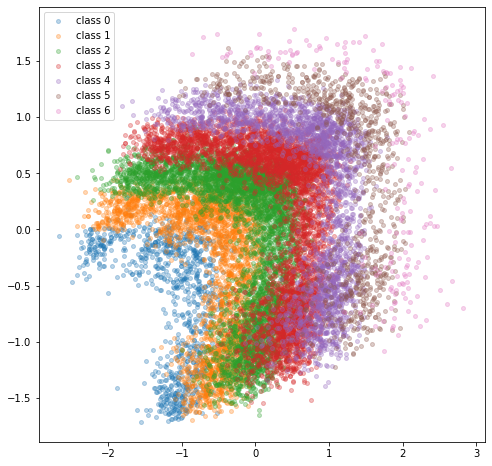

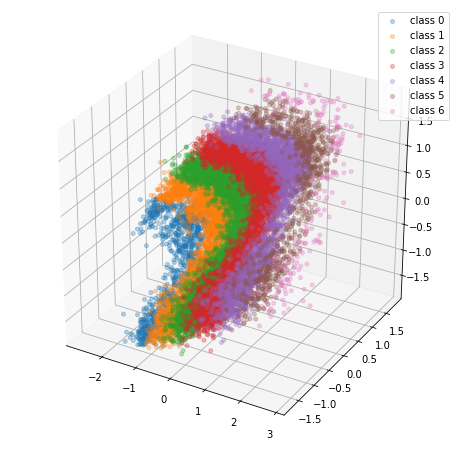

In [47]:
X_norm = MinMaxScaler().fit_transform(X)

pca2 = PCA(n_components=2)
pca2.fit(X_norm)
X_pca_2 = pca2.transform(X_norm)
print(pca2.explained_variance_ratio_)
print(np.sum(pca2.explained_variance_ratio_))
plt.figure(figsize = (8,8))
for class_label in unique_y:    
    plt.scatter(X_pca_2[y_discrete==class_label][:,0], X_pca_2[y_discrete==class_label][:,1],
                alpha=0.3, s=16, label='class '+str(class_label))
# plt.scatter(X_pca_2[:,0], X_pca_2[:,1], c=y, alpha=0.5)
plt.legend()
# plt.savefig('pca2.eps', format='eps')

pca3 = PCA(n_components=3)
pca3.fit(X_norm)
X_pca_3 = pca3.transform(X_norm)
print(pca3.explained_variance_ratio_)
print(np.sum(pca3.explained_variance_ratio_))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

for class_label in unique_y:
# for m, classs in [('o', 0)]:
    xs = X_pca_3[y_discrete==class_label][:,0]
    ys = X_pca_3[y_discrete==class_label][:,1]
    zs = X_pca_3[y_discrete==class_label][:,1]
    label = 'class ' + str(class_label)
    ax.scatter(xs, ys, zs, label=label, alpha=0.3, s=16)
plt.legend()
# plt.savefig('pca3.eps', format='eps')


[0.40847799 0.73346607 0.79834356 0.82926216 0.84865891 0.86241036
 0.87535344 0.88732997 0.89907418 0.9084608  0.91717909 0.92451023
 0.93107005 0.93725333 0.94211473]


<BarContainer object of 61 artists>

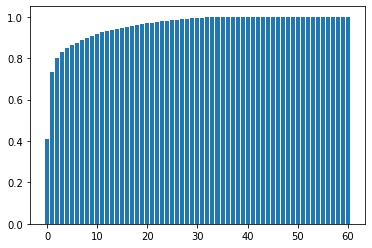

In [101]:
pca_all = PCA()
X_norm = MinMaxScaler().fit_transform(X)
pca_all.fit(X_norm)
X_pca_all = pca_all.transform(X_norm)
# print(pca_all.explained_variance_ratio_)
# print(np.sum(pca_all.explained_variance_ratio_))
cumul_var = np.cumsum(pca_all.explained_variance_ratio_)
print(cumul_var[:15])
plt.figure()
plt.bar(range(len(pca_all.explained_variance_ratio_)), cumul_var)

# Training
Possible models:
- Decision Trees
- QDA
- Gaussian Naive Bayes
- SVC OvO, OvR strategies
- KNN

Do we use PCA transformation?
Do we use reduced atributes?

For best models we use grid search technique to search for best parameters.

In [8]:
n_folds = 10

In [ ]:
#DTC

In [102]:
dtc_clf = DecisionTreeClassifier()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', dtc_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate (pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [103]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.7760029058901698
Accuracy score:  0.8019658435878462


In [9]:
dtc_clf = DecisionTreeClassifier()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', dtc_clf)])

X_train, X_test, y_train, y_test = train_test_split(X, y_discrete, stratify=y_discrete, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(pipeline.score(X_test, y_test))
print(geometric_mean_score(y_test, y_pred))

[[156  30   0   0   0   0   0]
 [ 29 425  69   0   0   0   0]
 [  0  75 773  76   0   0   0]
 [  0   0  85 748  38   0   0]
 [  0   0   0  53 435  18   0]
 [  0   0   0   0  26 142   8]
 [  0   0   0   0   0   6  33]]
0.8409302325581396
0.8368280519027328


In [105]:
#QDA

In [106]:
qda_clf = QuadraticDiscriminantAnalysis()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', qda_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate(pipeline, X, y_discrete, cv=cv, scoring=scoring)

C:\Users\Franul\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Franul\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Franul\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Franul\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Franul\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Franul\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Franul\anaconda3\li

In [107]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.39025760277034655
Accuracy score:  0.4444842155624508


In [11]:
qda_clf = QuadraticDiscriminantAnalysis()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', qda_clf)])
X_train, X_test, y_train, y_test = train_test_split(X, y_discrete, stratify=y_discrete, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(pipeline.score(X_test, y_test))
print(geometric_mean_score(y_test, y_pred))

[[135  43   8   0   0   0   0]
 [135 206 165  17   0   0   0]
 [ 17 161 580 151  15   0   0]
 [  1  23 410 309 119   9   0]
 [  0   3  92 157 178  75   1]
 [  0   0   4  10  59 100   3]
 [  0   0   0   0   1  32   6]]
0.46945736434108526
0.4103020979973276


C:\Users\Franul\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
#GNB

In [134]:
scaler = MinMaxScaler()
gnb = GaussianNB()
pipeline = Pipeline([('scaler', scaler), ('clf', gnb)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate (pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [135]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.5589771181868782
Accuracy score:  0.5013211515001408


In [12]:
gnb = GaussianNB()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', gnb)])
X_train, X_test, y_train, y_test = train_test_split(X, y_discrete, stratify=y_discrete, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(pipeline.score(X_test, y_test))
print(geometric_mean_score(y_test, y_pred))

[[145  41   0   0   0   0   0]
 [118 277 124   4   0   0   0]
 [ 49 193 458 219   5   0   0]
 [  1  65 170 384 247   4   0]
 [  0   7  37  82 263 117   0]
 [  0   0   0   9  27 115  25]
 [  0   0   0   0   2   4  33]]
0.5193798449612403
0.5934676691301756


In [109]:
#SVC ovr

In [125]:
svc_clf = SVC()
ovr_clf = OneVsRestClassifier(svc_clf)
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', ovr_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate(pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [126]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.6124070444467871
Accuracy score:  0.769333724591909


In [127]:
#SVC ovo

In [128]:
svc_clf = SVC()
ovr_clf = OneVsOneClassifier(svc_clf)
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', ovr_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate(pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [129]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.7591116994191415
Accuracy score:  0.821378909573118


In [17]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.7593445919479994
Accuracy score:  0.8195182135225731


In [13]:
svc_clf = SVC()
ovr_clf = OneVsOneClassifier(svc_clf)
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', ovr_clf)])
X_train, X_test, y_train, y_test = train_test_split(X, y_discrete, stratify=y_discrete, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(pipeline.score(X_test, y_test))
print(geometric_mean_score(y_test, y_pred))

[[164  22   0   0   0   0   0]
 [ 14 432  77   0   0   0   0]
 [  0  55 800  69   0   0   0]
 [  0   0  58 773  40   0   0]
 [  0   0   0  48 443  15   0]
 [  0   0   0   0  33 140   3]
 [  0   0   0   0   0  12  27]]
0.8617054263565892
0.8293213851895548


In [ ]:
#KNN

In [132]:
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
pipeline = Pipeline([('scaler', scaler), ('clf', knn)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate (pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [133]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.6434136990132522
Accuracy score:  0.7361423699193432


In [14]:
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
pipeline = Pipeline([('scaler', scaler), ('clf', knn)])
X_train, X_test, y_train, y_test = train_test_split(X, y_discrete, stratify=y_discrete, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(pipeline.score(X_test, y_test))
print(geometric_mean_score(y_test, y_pred))

[[152  34   0   0   0   0   0]
 [ 31 401  91   0   0   0   0]
 [  0 109 729  86   0   0   0]
 [  0   1 136 694  40   0   0]
 [  0   0   0 142 356   8   0]
 [  0   0   0   0  82  94   0]
 [  0   0   0   0   0  18  21]]
0.7587596899224807
0.6967272448278119


In [ ]:
#DTC with pca tranformation

In [144]:
scaler = MinMaxScaler()
pca = PCA(n_components=15)
dtc_clf = DecisionTreeClassifier()
pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('clf', dtc_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate (pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [139]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.676412006569619
Accuracy score:  0.6783315828957239


In [140]:
#QDA with pca tranformation

In [141]:
scaler = MinMaxScaler()
pca = PCA(n_components=15)
qda_clf = QuadraticDiscriminantAnalysis()
pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('clf', qda_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate(pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [142]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.5995564703533883
Accuracy score:  0.6099805550128531


In [ ]:
#GNB with pca tranformation

In [30]:
scaler = MinMaxScaler()
pca = PCA(n_components=15)
gnb = GaussianNB()
pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('clf', gnb)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate (pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [31]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.4609511231085734
Accuracy score:  0.5558888005181226


In [ ]:
#SVC ovr with pca tranformation

In [78]:
svc_clf = SVC()
scaler = MinMaxScaler()
pca = PCA(n_components=15)
ovr_clf = OneVsRestClassifier(svc_clf)

pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('clf', ovr_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate(pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [79]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.647282535508739
Accuracy score:  0.7840974156935199


In [143]:
#SVC ovo with pca tranformation

In [120]:
svc_clf = SVC()
scaler = MinMaxScaler()
pca = PCA(n_components=15)
ovr_clf = OneVsOneClassifier(svc_clf)

pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('clf', ovr_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate(pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [121]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.7115649098078871
Accuracy score:  0.7690777502067825


In [145]:
#KNN with pca tranformation

In [32]:
knn = KNeighborsClassifier()
scaler = MinMaxScaler()
pca = PCA(n_components=15)

pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('clf', knn)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate(pipeline, X, y_discrete, cv=cv, scoring=scoring)

In [33]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.6425073418040325
Accuracy score:  0.7450150683266695


In [153]:
knn = KNeighborsClassifier()
scaler = MinMaxScaler()
pca = PCA()

pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('clf', knn)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
param_grid ={'pca__n_components': [5, 7, 9, 11, 13, 15, 20, 25, 30, 40]}
grid_knn_pca = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='g-mean')
grid_knn_pca.fit(X, y_discrete)
print("The best parameters are %s with a score of %0.2f"
      % (grid_knn_pca.best_params_, grid_knn_pca.best_score_))

The best parameters are {'pca__n_components': 5} with a score of 0.69


In [154]:
grid_knn_pca.cv_results_

{'mean_fit_time': array([0.09100003, 0.08199999, 0.09600003, 0.103     , 0.11799998,
        0.12900002, 0.155     , 0.19000001, 0.21199999, 0.26699996]),
 'std_fit_time': array([0.00699998, 0.00399996, 0.00489897, 0.00640311, 0.00871781,
        0.0053851 , 0.00500004, 0.00774599, 0.00748335, 0.01099994]),
 'mean_score_time': array([0.05599997, 0.07200003, 0.09099998, 0.10600004, 0.12900002,
        0.14199998, 0.19300001, 0.26199999, 0.33199999, 0.46000006]),
 'std_score_time': array([0.00489895, 0.00399995, 0.00830661, 0.00663326, 0.00700001,
        0.00400012, 0.01345362, 0.01077032, 0.01661327, 0.03435109]),
 'param_pca__n_components': masked_array(data=[5, 7, 9, 11, 13, 15, 20, 25, 30, 40],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'pca__n_components': 5},
  {'pca__n_components': 7},
  {'pca__n_components': 9},
  {'pca__n_components': 11},
  {'pca

In [ ]:
#DTC redued atributes

In [34]:
dtc_clf = DecisionTreeClassifier()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', dtc_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate (pipeline, df_X_corr.values, y_discrete, cv=cv, scoring=scoring)

In [35]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.7639047840586979
Accuracy score:  0.782612658625098


In [ ]:
#QDA redued atributes

In [36]:
qda_clf = QuadraticDiscriminantAnalysis()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', qda_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate (pipeline, df_X_corr.values, y_discrete, cv=cv, scoring=scoring)

C:\Users\Franul\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [37]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.5088202843201979
Accuracy score:  0.5582366981058058


In [ ]:
#SVC ovr redued atributes

In [80]:
svc_clf = SVC()
ovr_clf = OneVsRestClassifier(svc_clf)
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', ovr_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate(pipeline, df_X_corr.values, y_discrete, cv=cv, scoring=scoring)

In [81]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.5444170388465267
Accuracy score:  0.7471887071391101


In [ ]:
#SVC ovo redued atributes

In [40]:
svc_clf = SVC()
ovr_clf = OneVsOneClassifier(svc_clf)
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', ovr_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate(pipeline, df_X_corr.values, y_discrete, cv=cv, scoring=scoring)

In [41]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.7373090507443483
Accuracy score:  0.8110200695650569


In [ ]:
#GNB redued atributes

In [82]:
scaler = MinMaxScaler()
gnb = GaussianNB()
pipeline = Pipeline([('scaler', scaler), ('clf', gnb)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate (pipeline, df_X_corr.values, y_discrete, cv=cv, scoring=scoring)

In [83]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.5964384207669081
Accuracy score:  0.5446130155267607


In [ ]:
#KNN redued atributes

In [42]:
scaler = MinMaxScaler()
knn = KNeighborsClassifier(n_neighbors=5)
pipeline = Pipeline([('scaler', scaler), ('clf', knn)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
cv_score = cross_validate (pipeline, df_X_corr.values, y_discrete, cv=cv, scoring=scoring)

In [43]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.5887066187377562
Accuracy score:  0.6849675557928062


In [ ]:
#SVC with rfecv selection

In [123]:
from sklearn.feature_selection import RFECV
svc_clf = SVC()
scaler = MinMaxScaler()
estimator_svc = SVC(kernel='linear')
rfe_selector_cv = RFECV(estimator=estimator_svc, min_features_to_select=30, step=5, verbose=0)
ovr_clf = OneVsOneClassifier(svc_clf)

pipeline = Pipeline([('scaler', scaler), ('RFECV', rfe_selector_cv), ('clf', ovr_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=5)
cv_score = cross_validate(pipeline, X, y_discrete, cv=cv, scoring=scoring)

['Age', 'International Reputation', 'Skill Moves', 'Weight', 'LS', 'ST', 'RS', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'HeadingAccuracy', 'ShortPassing', 'Dribbling', 'LongPassing', 'BallControl', 'SprintSpeed', 'Reactions', 'LongShots', 'Interceptions', 'Positioning', 'Vision', 'Composure', 'StandingTackle', 'SlidingTackle']


In [126]:
print('Gmean score: ', np.mean(cv_score['test_g-mean']))
print('Accuracy score: ', np.mean(cv_score['test_accuracy']))

Gmean score:  0.7115813546281571
Accuracy score:  0.7670930232558139


In [ ]:
#KNN with rfecv selection

In [17]:
estimator_svc = SVC(kernel='linear')
X_norm = MinMaxScaler().fit_transform(X)
estimator_svc = SVC(kernel='linear')
rfe_selector_cv = RFECV(estimator=estimator_svc, min_features_to_select=30, step=10, verbose=1)
rfe_selector_cv.fit(X_norm, y_discrete)
X_selected = rfe_selector_cv.transform(X_norm)
# X_selected = rfe_selector_cv.fit_transform(X, y_discrete)
# knn = KNeighborsClassifier()

# scaler = MinMaxScaler()
# pipeline = Pipeline([('scaler', scaler), ('clf', knn)])
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y_discrete, stratify=y_discrete, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(pipeline.score(X_test, y_test))

Fitting estimator with 61 features.
Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 61 features.
Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 61 features.
Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 61 features.
Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 61 features.
Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 61 features.
Fitting estimator with 51 features.


In [18]:
knn = KNeighborsClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_discrete, stratify=y_discrete, test_size=0.2, random_state=42)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(knn.score(X_test, y_test))

[[155  31   0   0   0   0   0]
 [ 30 396  97   0   0   0   0]
 [  0  90 741  93   0   0   0]
 [  0   0 145 682  44   0   0]
 [  0   0   0 132 360  14   0]
 [  0   0   0   0  66 109   1]
 [  0   0   0   0   0  17  22]]
0.7643410852713178


# Grid search
Chosen classifiers for grid-search:
- knn
- dtc
- svc

In [155]:
dtc_clf = DecisionTreeClassifier()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', dtc_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)

param_grid = {'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_leaf': [1, 3],
              'clf__class_weight': [None, 'balanced'],
              'clf__ccp_alpha': [0.0, 0.25, 0.5, 0.75],
              'clf__max_depth': [None, 5, 10],
              'clf__max_leaf_nodes': [None, 15, 30]}

grid_DTC_norm = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='g-mean')
grid_DTC_norm.fit(X, y_discrete)
print("The best parameters are %s with a score of %0.2f"
      % (grid_DTC_norm.best_params_, grid_DTC_norm.best_score_))


The best parameters are {'clf__ccp_alpha': 0.0, 'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_leaf_nodes': None, 'clf__min_samples_leaf': 3} with a score of 0.79


In [156]:
grid_DTC_norm.cv_results_

{'mean_fit_time': array([0.42909999, 0.39100001, 0.14899998, 0.15200002, 0.18399999,
        0.18000004, 0.15099998, 0.14599998, 0.14699998, 0.14300005,
        0.15600002, 0.16619995, 0.28400002, 0.28899996, 0.15999999,
        0.15799997, 0.20099998, 0.17800004, 0.42099998, 0.38999999,
        0.15999999, 0.16200006, 0.20499997, 0.20800002, 0.15599995,
        0.16200008, 0.15499997, 0.15300004, 0.16500003, 0.16399999,
        0.30599997, 0.30900004, 0.16600001, 0.16700001, 0.20300002,
        0.198     , 0.43400002, 0.40299995, 0.15600007, 0.15899997,
        0.202     , 0.19800003, 0.15499997, 0.153     , 0.15000002,
        0.147     , 0.15699999, 0.15899999, 0.29199998, 0.28500001,
        0.16600001, 0.15700004, 0.19899993, 0.19899998, 0.42099998,
        0.39099998, 0.174     , 0.178     , 0.223     , 0.21799996,
        0.172     , 0.16799998, 0.15900004, 0.152     , 0.16100001,
        0.16100001, 0.31700001, 0.31100001, 0.16999996, 0.16500001,
        0.21399996, 0.22399998,

In [15]:
scaler = MinMaxScaler()
dtc = DecisionTreeClassifier(criterion='gini', min_samples_leaf=3, 
                             class_weight='balanced',ccp_alpha=0, 
                             max_depth=10, max_leaf_nodes=None)
pipeline = Pipeline([('scaler', scaler), ('clf', dtc)])
X_train, X_test, y_train, y_test = train_test_split(X, y_discrete, stratify=y_discrete, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Best dtc model score: ', pipeline.score(X_test, y_test))
print('Best dtc model g-mean score: ', geometric_mean_score(y_test, y_pred))
print('Best dtc model confusion matrix: \n', confusion_matrix(y_test, y_pred))
dtc_clf = DecisionTreeClassifier()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', dtc_clf)])



Best dtc model score:  0.8322480620155038
Best dtc model g-mean score:  0.8321304683703631
Best dtc model confusion matrix: 
 [[159  26   0   1   0   0   0]
 [ 51 407  63   2   0   0   0]
 [  0  75 764  83   2   0   0]
 [  0   0  60 742  69   0   0]
 [  0   0   0  32 437  37   0]
 [  0   0   0   1  21 142  12]
 [  0   0   0   0   0   6  33]]
[[153  33   0   0   0   0   0]
 [ 34 421  68   0   0   0   0]
 [  0  79 764  81   0   0   0]
 [  0   0  86 746  39   0   0]
 [  0   0   0  55 435  16   0]
 [  0   0   0   0  28 141   7]
 [  0   0   0   0   0   6  33]]
0.8350387596899225
0.8308328100688049


In [162]:
svc_clf = SVC()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('clf', svc_clf)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)

param_grid = [
  {'clf__C': [0.01, 0.1, 1 , 10, 100], 
   'clf__kernel': ['linear'],
   "clf__class_weight": [None, 'balanced']},
  {'clf__C': [0.01, 0.1, 1 , 10, 100, 1000], 
   'clf__gamma': [0.01, 0.001, 0.0001, 0.00001],
   'clf__kernel': ['rbf'], 
   "clf__class_weight": [None, 'balanced']},
 ]

grid_SVC_norm = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='g-mean')
grid_SVC_norm.fit(X, y_discrete)
print("The best parameters are %s with a score of %0.2f"
      % (grid_SVC_norm.best_params_, grid_SVC_norm.best_score_))


The best parameters are {'clf__C': 1000, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'rbf'} with a score of 0.81


In [163]:
grid_SVC_norm.cv_results_

{'mean_fit_time': array([11.38119993, 15.11000004,  7.65569999,  9.8842    ,  6.97790003,
         7.81620002,  9.79099998, 10.19830005, 27.51829996, 25.01700001,
        29.88829997, 29.90710006, 26.68199999, 26.48640003, 54.33479993,
        52.39259999, 56.21720002, 54.70049994, 23.30220006, 29.63540003,
        29.46350002, 28.57990005, 34.64129999, 44.22919998, 52.43790002,
        53.71289997, 16.4973999 , 24.75369995, 29.25439997, 29.93479996,
        19.81309996, 28.2194    , 41.18380005, 41.26339998,  8.84210005,
        14.09060001, 19.88930004, 23.55560005, 10.86669998, 18.09100003,
        27.95909996, 40.16130002,  6.11120007,  9.75259995, 13.93180001,
        21.17229996,  8.26750004, 13.89069998, 20.70780003, 28.38289995,
         6.42310004,  8.23019998, 10.24489994, 14.33340011,  6.40439994,
         9.23180001, 12.37040002, 17.99149997]),
 'std_fit_time': array([0.21144919, 0.61464682, 0.35697402, 0.46721173, 0.49933591,
        0.15808024, 0.86740605, 0.9229643 , 2.3

In [165]:
scaler = MinMaxScaler()
svc = SVC(C=1000, kernel='rbf', class_weight='balanced', gamma=0.01)
pipeline = Pipeline([('scaler', scaler), ('clf', svc)])
X_train, X_test, y_train, y_test = train_test_split(X, y_discrete, stratify=y_discrete, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Best svc model score: ', pipeline.score(X_test, y_test))
print('Best svc model g-mean score: ', geometric_mean_score(y_test, y_pred))
print('Best svc model confusion matrix: \n', confusion_matrix(y_test, y_pred))

Best svc model score:  0.8275968992248062
Best svc model g-mean score:  0.8457547755360808
Best svc model confusion matrix: 
 [[173  13   0   0   0   0   0]
 [ 58 420  45   0   0   0   0]
 [  0 103 737  84   0   0   0]
 [  0   0  72 726  73   0   0]
 [  0   0   0  38 426  42   0]
 [  0   0   0   0  13 154   9]
 [  0   0   0   0   0   6  33]]


In [169]:
knn = KNeighborsClassifier()
scaler = MinMaxScaler()
pca = PCA()

pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('clf', knn)])
scoring = {'g-mean': make_scorer(geometric_mean_score), 'accuracy': make_scorer(accuracy_score)}
cv = StratifiedKFold(n_splits=n_folds)
param_grid ={'pca__n_components': [5, 7, 9, 11, 13, 15, 20, 25, 30, 40],
             'clf__weights': ['uniform', 'distance'],
             'clf__n_neighbors': np.linspace(3, 15, 7).astype(np.int)}


grid_KNN_norm = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='g-mean')
grid_KNN_norm.fit(X, y_discrete)
print("The best parameters are %s with a score of %0.2f"
      % (grid_KNN_norm.best_params_, grid_KNN_norm.best_score_))


The best parameters are {'clf__n_neighbors': 5, 'clf__weights': 'distance', 'pca__n_components': 5} with a score of 0.70


In [170]:
grid_KNN_norm.cv_results_

{'mean_fit_time': array([0.09169998, 0.08660007, 0.09780004, 0.10599997, 0.1188    ,
        0.13419995, 0.14990001, 0.19519999, 0.20119996, 0.28239994,
        0.08830004, 0.08470001, 0.0977    , 0.10810003, 0.12869999,
        0.13200009, 0.1555999 , 0.19179993, 0.21430008, 0.25710003,
        0.08569999, 0.08470004, 0.09510002, 0.10480001, 0.12129996,
        0.12919993, 0.15560002, 0.17800007, 0.22170007, 0.29020007,
        0.08669999, 0.08630004, 0.10449998, 0.104     , 0.11520002,
        0.12369995, 0.15649996, 0.19059992, 0.21800001, 0.26730001,
        0.08399999, 0.08119993, 0.09960003, 0.10780001, 0.11979997,
        0.1273    , 0.15759997, 0.19159997, 0.22470005, 0.27049999,
        0.08539999, 0.08320003, 0.09560006, 0.1053    , 0.11880004,
        0.13000002, 0.15829995, 0.18989999, 0.21700001, 0.27149999,
        0.08760002, 0.08240004, 0.09909997, 0.10789998, 0.12089994,
        0.13109994, 0.15290008, 0.19520004, 0.22020001, 0.26810002,
        0.08659999, 0.0825    ,

In [8]:
scaler = MinMaxScaler()
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
pca = PCA(n_components=5)
pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('clf', knn)])
X_train, X_test, y_train, y_test = train_test_split(X, y_discrete, stratify=y_discrete, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Best knn model score: ', pipeline.score(X_test, y_test))
print('Best knn model g-mean score: ', geometric_mean_score(y_test, y_pred))
print('Best knn model confusion matrix: \n', confusion_matrix(y_test, y_pred))

Best knn model score:  0.7897674418604651
Best knn model g-mean score:  0.7311146672895158
Best knn model confusion matrix: 
 [[154  32   0   0   0   0   0]
 [ 19 412  91   1   0   0   0]
 [  0  84 740 100   0   0   0]
 [  0   0 108 710  53   0   0]
 [  0   0   0  90 396  20   0]
 [  0   0   0   0  57 115   4]
 [  0   0   0   0   0  19  20]]


We recieve best results for SVC with class weights as we have unbalanced classes, rbf kernel with coefficent gamme equal to 0.01 and value of regularization parameter C = 1000

At the end I wanted to see which examples used for testing are not classified well. We could use outcome of any classifier but I was the most curious about KNN classifier. We plot whole PCA space and then lower alpha value for transparency to see which one are not classified well. We see that those examples lay on boundaries of two classes.

In [18]:
Xwrong = X_test[y_pred!=y_test]
Xright = X_test[y_pred==y_test]

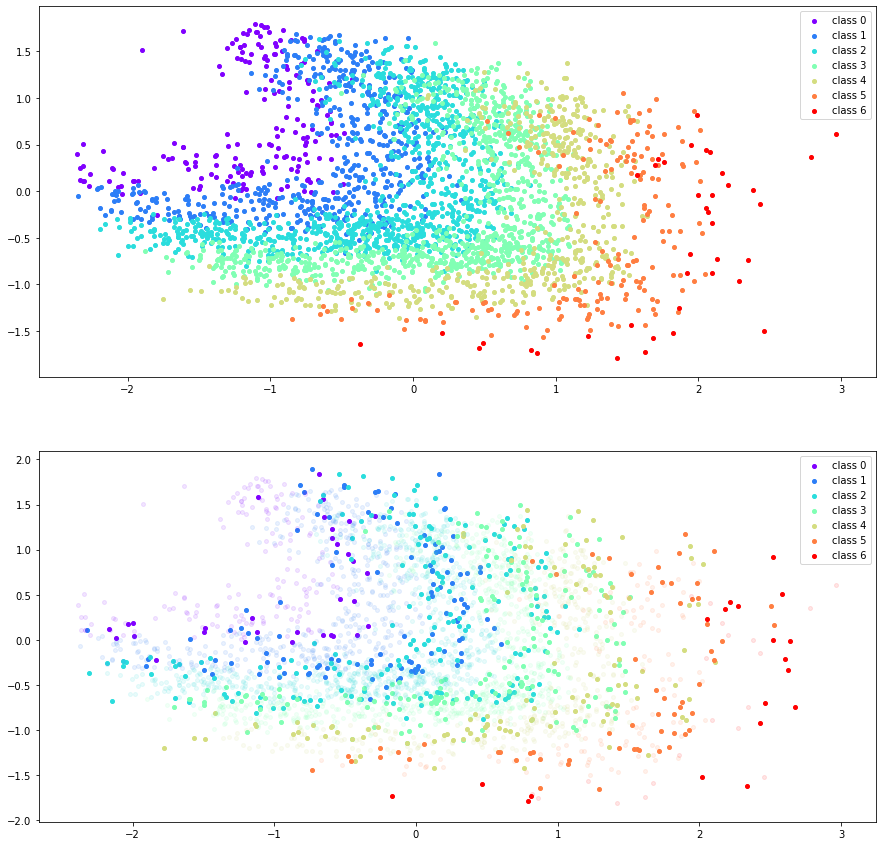

In [33]:
X_norm = MinMaxScaler().fit_transform(X_test)
y_discrete = y_test
pca2 = PCA(n_components=2)
pca2.fit(X_norm)
X_pca_2 = pca2.transform(X_norm)


fig, axs = plt.subplots(2, figsize=(15,15))
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(unique_y)))
# axs[0].plot(x, y)
# axs[1].plot(x, -y)
for class_label, color in zip(unique_y, colors):    
    axs[0].scatter(X_pca_2[y_discrete==class_label][:,0], X_pca_2[y_discrete==class_label][:,1],
                alpha=1, s=16, label='class '+str(class_label), color=color)
axs[0].legend()

y_discrete = y_test
X_norm = MinMaxScaler().fit_transform(Xwrong)
X_pca_2 = pca2.transform(X_norm)    
for class_label, color in zip(unique_y, colors):    
    axs[1].scatter(X_pca_2[y_discrete[y_pred!=y_test]==class_label][:,0], X_pca_2[y_discrete[y_pred!=y_test]==class_label][:,1],
                alpha=1, s=16, label='class '+str(class_label), color=color)
axs[1].legend()

X_norm = MinMaxScaler().fit_transform(Xright)
X_pca_2 = pca2.transform(X_norm) 
for class_label, color in zip(unique_y, colors): 
    axs[1].scatter(X_pca_2[y_discrete[y_pred==y_test]==class_label][:,0], X_pca_2[y_discrete[y_pred==y_test]==class_label][:,1],
                alpha=0.1, s=16, label='class '+str(class_label), color=color)

[0.43103021 0.29280977]
0.7238399767209605


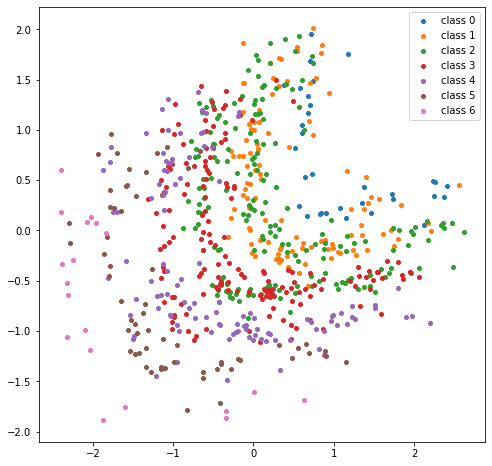

In [19]:
X_norm = MinMaxScaler().fit_transform(Xwrong)
y_discrete = y_test
pca2 = PCA(n_components=2)
pca2.fit(X_norm)
X_pca_2 = pca2.transform(X_norm)
print(pca2.explained_variance_ratio_)
print(np.sum(pca2.explained_variance_ratio_))
plt.figure(figsize = (8,8))
for class_label in unique_y:    
    plt.scatter(X_pca_2[y_discrete[y_pred!=y_test]==class_label][:,0], X_pca_2[y_discrete[y_pred!=y_test]==class_label][:,1],
                alpha=1, s=16, label='class '+str(class_label))
plt.legend()

[0.42388727 0.31749052]
0.7413777946047424


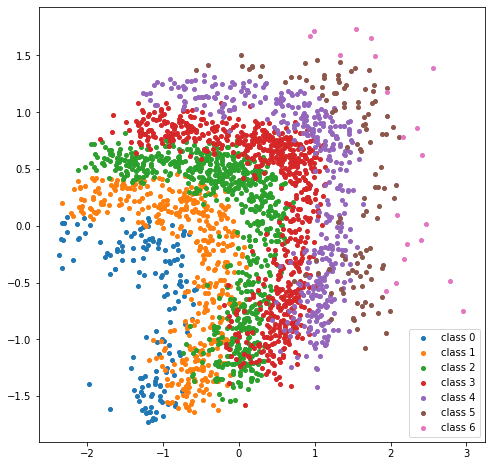

In [20]:
X_norm = MinMaxScaler().fit_transform(Xright)
y_discrete = y_test
pca2 = PCA(n_components=2)
pca2.fit(X_norm)
X_pca_2 = pca2.transform(X_norm)
print(pca2.explained_variance_ratio_)
print(np.sum(pca2.explained_variance_ratio_))
plt.figure(figsize = (8,8))
for class_label in unique_y:    
    plt.scatter(X_pca_2[y_discrete[y_pred==y_test]==class_label][:,0], X_pca_2[y_discrete[y_pred==y_test]==class_label][:,1],
                alpha=1, s=16, label='class '+str(class_label))
plt.legend()